# Getting started with the JASMIN Notebook Service with GPUs enabled

This notebook demonstrates the basics of working on the JASMIN Notebook Service with GPUs enabled.

It covers the following topics:
- [Who can access the GPU-enabled Notebook Service?](#Who-can-access-the-GPU-enabled-Notebook-Service?)
- [Which packages are available by default?](#Which-packages-are-available-by-default?)
- [GPU availability](#GPU-availability)
- [Understanding the nvidia-smi command output](#Understanding-the-nvidia-smi-command-output)
- [Resource allocation](#Resource-allocation)
- [Software environments and Machine Learning packages](#Software-environments-and-Machine-Learning-packages)
- [Guidelines and Best Practices](#Guidelines-and-Best-Practices)
- [A simple PyTorch workflow using GPUs](#A-simple-PyTorch-workflow-using-GPUs)


<a name="who"></a>
## Who can access the GPU-enabled Notebook Service?

The service is available to all JASMIN users that have been granted access to the ORCHID (GPU) cluster. [Click here](https://accounts.jasmin.ac.uk/services/additional_services/orchid/) to apply.

## Which packages are available by default?

Check the top-right corner of a Notebook session to see which _kernel_ that is being used. If you don't need any specialist Machine Learning (ML) libraries, you would typically choose `Python 3 + Jaspy` as this has many of the common open-source packages used within environmental science:
<br/><br/>
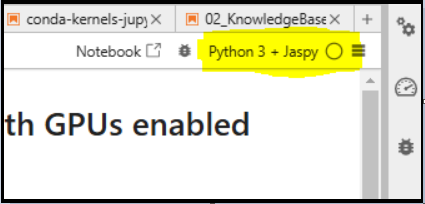

You can click on the name of the _kernel_, and select a different one.

However, if you want to work with GPUs, you are likely to want to install other packages that are common in ML, such as **[PyTorch](https://pytorch.org)** and **[TensorFlow](https://www.tensorflow.org/)**. We will come back to this topic soon.

## GPU availability

In order to check that your notebook is running on a server with GPUs, you can use the built-in NVIDIA commands, such as:

In [7]:
#!nvidia-smi   # Remove the "#" at the start of this line to execute this cell

If GPUs are enabled, the output should look like this:

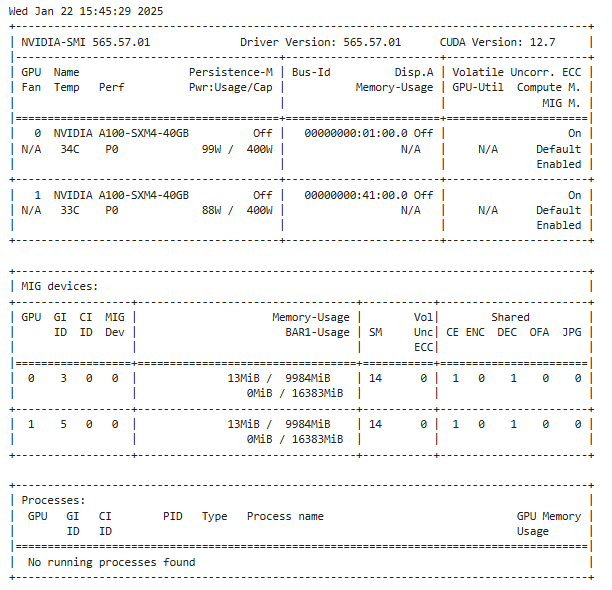

## Understanding the nvidia-smi command output

### 1. The Header section 

The first section includes:
- **CUDA Version: 12.7**: The version of the CUDA toolkit that the NVIDIA driver supports.
- **GPU 0 / GPU 1**: There are two physical NVIDIA A100 GPUs in the system.  
- **Name**: The model is `NVIDIA A100-SXM4-40GB`. Each GPU has 40GB of on-board memory.   
- **Memory-Usage**: Shows `N/A` because these GPUs are in MIG mode (Multi-Instance GPU), so memory usage is not reported here in the usual way. Memory usage for MIG slices is shown in the dedicated MIG section (below).  
- **GPU-Util**: Also `N/A` for the same reason (MIG is active, so usage must be looked at per MIG instance). 

### 2. The MIG section

The second section introduces **[MIG (Multi-Instance GPU)](https://www.nvidia.com/en-gb/technologies/multi-instance-gpu/)**. When a GPU is running in **MIG Mode**, it allows each GPU to be partitioned into multiple _instances_, each acting as a smaller independent, or _virtual_, GPU. Because MIG is turned on, you see "N/A" in the normal memory usage fields. Instead, you have a dedicated table for each MIG device:
- **GPU**: This repeats the GPU ID (0 or 1).  
- **GI ID** (GPU Instance) and **CI ID** (Compute Instance): Each MIG slice is defined by a GPU instance and a compute instance.
- **MIG Dev**: The MIG device index.  
- **Memory-Usage (13MiB / 9984MiB)**: Each MIG slice here is allocated around 10GB (`9984MiB`) of GPU memory. Currently, only 13 MiB is being used, likely overhead.  
- **BAR1-Usage**: This is the amount of memory mapped via the BAR1 aperture (used for buffer transfers).  
- **CE / ENC / DEC / OFA / JPG**: These columns refer to hardware encoder/decoder and other specialized engines available to each MIG slice.

### 3. The Processes section

The third section, _processes_, indicates what is running on the GPU/MIG instances:
- **No running processes found**: There were no active workloads on the GPUs or MIG instances at the time this command was run.

**In short**: There are two physical A100 GPUs. Each is in MIG mode and is presenting one _virtual_ GPU instance with 10GB of memory. Currently, neither GPU has any running processes, so they're essentially idle. The top-level memory usage fields are "N/A" because MIG splits the GPU resources, and the usage is shown in the MIG devices table below.

### Getting the GPU and MIG device IDs

The following command will give you the exact IDs of the available GPUs and MIG instances:

In [8]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-2927d07e-3fe9-7904-9e08-b08b82d9a37d)
  MIG 1g.10gb     Device  0: (UUID: MIG-6e95ef19-5145-571b-b040-7e731f1c1af3)
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-e109d8d9-923e-7235-0429-96b7fdbcbd30)
  MIG 1g.10gb     Device  0: (UUID: MIG-b4bcd4f3-6f69-516d-9404-b5ada80d760b)


## Resource allocation

The current allocation of GPUs to the JASMIN Notebook Service is as follows:
- 1 GPU Node serves 4 physical GPUs (`NVIDIA A100-SXM4-40GB`).
- Each GPU is partitioned, using MIG, into 4 _virtual_ GPU instances.
- Each user is allocated 2 _virtual_ GPU instances for their own notebook instance.
- Each _virtual_ GPU instance has 10GiB of memory.

## Software environments and Machine Learning packages

In the current release of the Notebook Service, users are required to install their own ML packages for use with GPUs. We recommend this approach:

1. Create a virtual environment ("_venv_"), for example `ml-venv`. Use this [guide to creating a virtual environment for the JASMIN Notebook Service](https://help.jasmin.ac.uk/docs/interactive-computing/creating-a-virtual-environment-in-the-notebooks-service/)
2. Install the packages you require into that _venv_. For example, if you needed `pytorch` and `torchvision`, you would run `pip install torch torchvision` (including specific versions if needed). **NOTE: Many ML packages are very big - this can take several minutes.**
3. Be sure to follow the instructions for installing `ipykernel` into your _venv_ and running the relevant command to install the kernel so that JupyterHub can locate it and list it as one of the available kernels. Use the name of your _venv_ as the name of the _kernel_.
4. Once you have installed your kernel, it should appear as an option in the Launcher as outlined in green in the diagram below. The Launcher is accessible from the File menu.
<br/><br/>

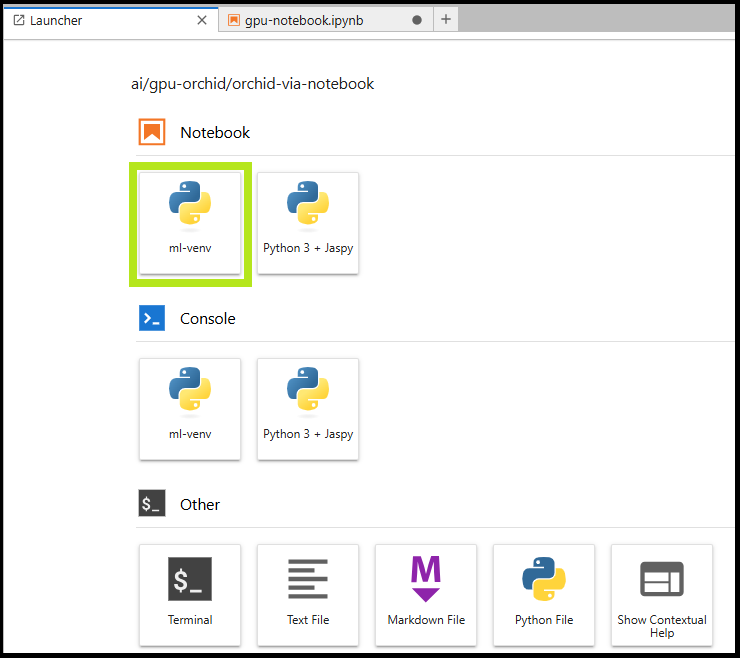

### Handling multiple/conflicting versions of software packages

It is common to find that different workflows will require different versions of software packages. In the fast-moving world of ML, the libraries and their dependencies often change and this can cause problems when trying to work within a single software environment.

If you encounter this kind of problem, we recommend that you create multiple virtual environments and their associated _kernels_. You can then select the appropriate _kernel_ for each notebook. It may also be worth investing the time in capturing exact versions of the relevant packages so that you can reproduce your environment if necessary. Python packages often use a requirements file (typically named `requirements.txt`) to capture the dependencies. For example:

<div style="font-family: 'Courier New', monospace; background-color: #111111; color: white; padding:10px; width:300px; margin: 20px;">
    scikit-learn==1.5.1<br/>
    torch==2.5.1+cu124<br/>
    torchvision==0.20.1+cu124
</div>

All packages listed in a requirements file can be installed with a single command:
<div style="font-family: 'Courier New', monospace; background-color: #111111; color: white; padding:10px; width:300px; margin: 20px;">
$ pip install -r requirements.txt
</div>


## Importing PyTorch or TensorFlow and testing that they work with CUDA

CUDA is system that connects the Python libraries to the GPU system (on NVIDIA hardware). When we install PyTorch, or many other ML packages, it should automatically detect CUDA if it is available. Assuming that you have followed the instructions to create a _venv_ and install `PyTorch`, then you can check for CUDA with:

In [9]:
import torch
print("Is CUDA available? ", torch.cuda.is_available())

Is CUDA available?  True


The same thing is possible with `TensorFlow`:

In [10]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### Warning about large ML packages and $HOME directory disk quota

Please be aware that installing these packages into your `$HOME` directory will require multiple Gigabytes of free space. If you are near your quota (100GB), then the installation may fail. It is important to note that an **installation failure may not report a violation of disk quota** even if that is the underlying problem. See the [`$HOME` directory documentation](https://help.jasmin.ac.uk/docs/getting-started/storage/#home-directory) for details on checking your current disk usage.

## Guidelines and Best Practices

### Efficient GPU usage

Please make use of GPUs efficiently in your code. If you only need CPUs, then please use the standard Notebook service. One way to ensure that the resource is being efficiently used is to stop your notebook server, via the Hub Control Panel (see the File menu) when not actively needed. Be sure to save your notebook before stopping the server.

### Memory and Resource Limits

The per-user memory limit for a given notebook is given in the bar below (typically 16GB). On the GPU architecture there is 10GiB per virtual GPU.

### Scaling up your workflows

Experienced JASMIN users will be familiar with the resource limitations of the Notebook Service. Whilst it is great for prototyping, scientific notebooks and code-sharing, it does not suit large multi-process and long-running workflows. The [LOTUS cluster](https://help.jasmin.ac.uk/docs/batch-computing/) is provided for larger workflows, and it includes the [ORCHID partition](https://help.jasmin.ac.uk/docs/batch-computing/orchid-gpu-cluster/) for GPU usage.

We recommend that you use the GPU-enabled Notebook Service to develop and prototype your ML workflows, and migrate them to ORCHID if they require significantly more compute power. Please contact the [JASMIN Helpdesk](mailto:support@jasmin.ac.uk) if you would like advice on how to migrate your workflows.

## A simple PyTorch workflow using GPUs

We have taken this basic ML workflow from the [PyTorch documentation](https://www.learnpytorch.io/01_pytorch_workflow/) to show it working on JASMIN Notebook Service with GPUs. This should be considered as a simple demonstration and not a recipe that you should copy and paste for your own workflows. The workflow include many references to the `device` (i.e. `cuda`) and moving data between the CPU and GPU device, in order to optimise processing on the best hardware.

In [11]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.5.1+cu124'

In [12]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [13]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [14]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

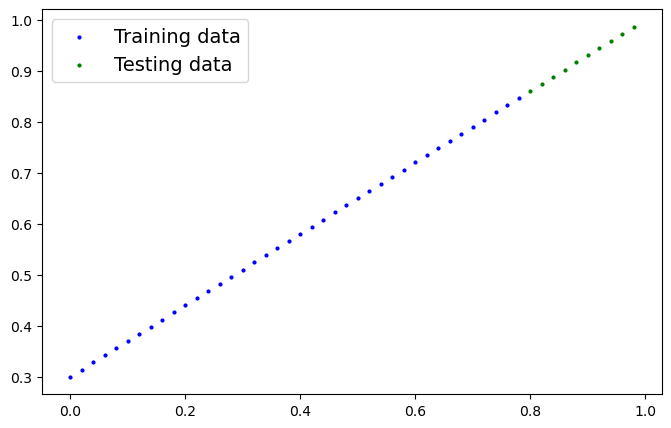

In [15]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(8, 5))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

plot_predictions(X_train, y_train, X_test, y_test)

In [16]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [17]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [18]:
# Set model to GPU if it's available, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

In [19]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [20]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [21]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [22]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

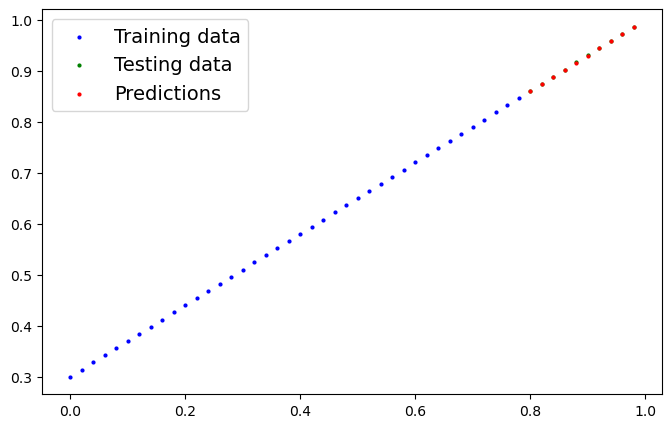

In [23]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

In [24]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_1.pth


In [25]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH, weights_only=False))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [26]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

### Good luck!

You have now built and trained your first two neural network models in PyTorch!

Remember, this example is just given to help you get an understanding of an ML workflow that includes managing data and processing on different devices: GPU (MIGs) for model training and usage; CPU for viewing, plotting and processing in the Notebook. Good luck with your GPU journey!